# N-body Gravitational Integrators

*Author: Aaron Geller <br/>
(drawing from references embedded within this notebook) <br/>
March 2023*

---

Gravity shapes many of the processes in the Universe, from planetary system scales up through cosmological scales.  In this workshop you will learn how to build a gravitational integrator from scratch in Python to model different self-gravitating systems.

Let's start by remembering that the force, $F$, of gravity is defined as:

$$
\overrightarrow{F} = -\frac{Gm_im_j}{r^3} \overrightarrow{r} \\
$$

where, $m_i$ and $m_j$ are the masses of two different particles, separated by a distance $r$.  

We will work in cartesian coordinates, so that we have positions and velocities as 

$$
X_i = [x_i, y_i, z_i] \\
V_i = [vx_i, vy_i, vz_i]
$$

From Newton's Second Law, we also know that $\overrightarrow{F} = m\overrightarrow{a}$, and for a system of particles we can write the acceleration, $a$, as:

$$
a_i = G \sum_{i \neq j} m_j \frac{X_j - X_i}{|X_j - X_i|^3}
$$

where $G$ is the Gravitational constant.

The goal of this workshop is to develop methods to advance a set of particles that start with initial positions and velocities along trajectories that are determined by the force of gravity at specific time steps.

In [ ]:
# import the necessary libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
from scipy.integrate import odeint

from astropy import units, constants

%matplotlib inline

# 1. First we will consider planetary systems

In this regime, as long as the star is much much more massive than the planet, we can make an approximation that the star stays fixed and only the planet moves.  This simplifies the calculation. 

(Of course this particular problem can be solved analytically, but we'll build off of this to model more complex systems that cannot be solved analytically.)

For this example, we will work in units of solar masses, AU and years (for convenience).  It often helps to define $G$ in these units to use later on.

In [ ]:
# define of Gravitational constant in our desired units
# using units of solar masses, AU and years
G = constants.G.to(units.AU**3./units.solMass/units.yr**2.).value

## 1.1 Let's start by defining the initial conditions

We'll have a planet orbitting a $M$ = 1$M_\odot$ star at a semi-major axis of $a$ = 1 AU with a circular orbit.  The [equation for the velocity ($v$) of a circular orbit](https://en.wikipedia.org/wiki/Circular_orbit) is:

$$
v_{circular} = \sqrt{\frac{GM}{a}}
$$

Create initial conditions for $r$ and $v$ in 2 dimensions that we can use to start the planet on its orbit.  

<i>Hint: You should offset the planet from zero in one direction and give it an initial velocity in another direction.</i>

In [ ]:
# initial conditions
M = 1. # solar masses
sma = 1. # AU

v_circ = (G*M/sma)**0.5 # assuming a circular orbit
X0 = [sma, 0., 0.]
V0 = [0., v_circ, 0.]

Also, create an array of times that you want to integrate the orbit along.  I recommend that you integrate for at least 2 orbital periods (e.g., if you chose a 1 AU orbit around a $1 M_\odot$ star, you should integrate for 2 years).  You should choose many hundreds (and maybe thousands) of time steps within the range.

<i>Hint: you can use ```np.arange``` to create your array of time values, given the start, end and step size.</i>

In [ ]:
t_arr = np.arange(0., 2., 1e-4)

## 1.2 Solving ODEs with ```scipy```

For this single planet example, we can integrate the orbit using an ordinary differential equations (ODE) solver.  Here we have a system of three second-order ODEs, one for each dimensions in the problem. For instance, in the $x$ dimension we have:

$$
\frac{d^2x}{dt^2} = -\frac{GM}{r^3}x
$$

And we have similar equations for the $y$ and $z$ dimensions.

The first step in solving this system of ODEs is to convert them to a system of first-order ODEs of the form:

$$
\frac{d\Psi}{dt} = f(\Psi,t)
$$

The vector $\Psi(t)$ is called the "state vector", and we can define the terms in the equation above more explicitly as:

$$
\Psi(t) = 
    \begin{bmatrix} 
        x(t) \\ 
        y(t) \\ 
        z(t) \\
        v_x(t) \\
        v_y(t) \\
        v_z(t) \\
    \end{bmatrix} 
$$

$$
f(\Psi,t) = 
    \begin{bmatrix}
        v_x(t) \\
        v_y(t) \\
        v_z(t) \\
        a_x(t) \\
        a_y(t) \\
        a_z(t) \\
    \end{bmatrix} = 
    \begin{bmatrix}
        v_x(t) \\
        v_y(t) \\
        v_z(t) \\
        F_x/m \\
        F_y/m \\
        F_z/m \\
    \end{bmatrix} =
    \begin{bmatrix}
        v_x(t) \\
        v_y(t) \\
        v_z(t) \\
        -\frac{GM}{r^3}x \\
        -\frac{GM}{r^3}y \\
        -\frac{GM}{r^3}z \\
    \end{bmatrix}    
$$


In Python we can use [```scipy.integrate.odeint```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) to solve this equation.   ```odeint``` has three required arguments. The first is the name of a Python function that defines $f(\Psi,t)$. The second argument is a state vector (specified as an array) containing the initial conditions. The final argument is an array containing the time points for which to solve the system. 

The output is a two-dimensional array of state vectors for each time point. The first index specifies the time point, and the second index specifies the element of the state vector.

Below, write a function for $f$ that has arguments of $\Psi$ at time $t$ and time (and I also suggest sending the stellar mass and the gravitational constant), and returns the array of values for $f(\Psi,t)$ as written above. 

In [ ]:
## Define function to return f(X,t)
def f_func(X, time, M, G):
    f = np.zeros(6)
    f[0:3] = X[3:6]
    r = np.linalg.norm(X[0:3]) # get the length of the vector
    f[3:6] = -(G*M*X[0:3])/r**3
    return f

Now use your initial conditions and time array with scipy's ```odeint``` to solve for the positions (and velocities) of your planet over time.  Use the ```full_output = True``` flag to ```odeint``` return a dict with diagnostic information, and print that dict.  The "message" key of this diagnostic dict should say "Integration successful."  (The content of this dict are defined in the [```odeint``` documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html).)

In [ ]:
XX = X0 + V0

X, infodict = odeint(f_func, XX, t_arr, args=(M, G), full_output = True)

infodict

## 1.3 Now let's analyze and plot the results.

### 1.3.1 It is important to keep track of the total energy and angular momentum.

Each of these quantities should be conserved.  Therefore we can judge the accuracy of our integtation scheme by tracking the energy and angular momentum over time.  Write functions below that will calculate the total energy of the system:

$$
E = KE + PE
$$

and the total angular momentum of the system:

$$
L = mX \times V
$$

In [ ]:
# I will exclude the planet mass since that will get divided out in the end
def get_E_single(X, V, M, G):
    return 0.5*np.linalg.norm(V, axis=1)**2. - G*M/np.linalg.norm(X, axis=1)
    
def get_L_single(X, V):
    return np.cross(X, V, axis=1)

### 1.3.2 I also recommend that you write a function to produce a figure.

This way you can reuse it later on to create similar figures using different input data.  I suggest that you plot the $(x_i, y_i)$ positions at each time step, and then also plot the energy vs. time and the angular momentum vs. time.  (So, this function should produce three plots.)  

Typically when we look at the energy and angular momentum, we plot the fractional difference from the initial value (e.g., plotting $|E - E_{t=0}|/E_{t=0}$ ).  This way, we can monitor the error on these, which is a more important diagnostic than the full magnitude of the quantity for our purposes.  If the energy (and/or angular momentum) error is large, then the results are not accurate.

In [ ]:
def create_figure_single(X_arr, t_arr, E, L):
    
    # make a grid so that I can have the x,y plot on top and then the energy and angular momentum plots below
    # the bottom plots share an x-axis
    f = plt.figure(figsize = (4,8))
    outer = gridspec.GridSpec(2, 1, height_ratios = [1.5, 1], figure = f) 
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])
    ax1 = plt.subplot(gs1[0])
    gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[1], hspace = 0)
    ax2 = plt.subplot(gs2[0])
    ax3 = plt.subplot(gs2[1])
    
    ax1.plot(X_arr[:,0],X_arr[:,1])
    ax1.plot([0],[0],'x', color='black')
    ax1.set_xlabel('x [AU]')
    ax1.set_ylabel('y [AU]')
    ax1.set_xlim(-1,1)
    ax1.set_ylim(-1,1)
    ax1.axis('equal')

    ax2.plot(t_arr, abs((E - E[0])/E[0]))
    ax2.set_xlabel('time [yr]')
    ax2.set_ylabel('|(E - E0)/E0|')
    ax2.set_yscale('log')

    ax3.plot(t_arr, abs((L - L[0])/L[0]))
    ax3.set_xlabel('time [yr]')
    ax3.set_ylabel('|(A - A0)/A0|')
    ax3.set_yscale('log')
        
    return (f, ax1, ax2, ax3)

Now use the results from ```odeint``` to calculate the energy and angular momentum at each time point and plot the results (using the functions you created above). 

In [ ]:
# calculate energy and angular momentum
E = get_E_single(X[:,0:3], X[:,3:6], M, G)
L = get_L_single(X[:,0:3], X[:,3:6])

# create the plot
_ = create_figure_single(X[:,0:3], t_arr, E, L)

### Questions to consider:

- What was the maximum energy error that your code reached here?  
- How does this energy error depend on your chosen time step?

This ODE solver will define our "gold standard" in energy and angular momentum conservation that we will try to acheive with our numerical solvers for other problems below.  (Note that the overall error in ```odeint``` can be controled with the ```rtol``` or ```atol``` input parameters.)

Though this method clearly works well for our "toy" planet problem, it will not be appropriate for systems of many particles.  Therefore for the remainder of this workshop, we will develop different numerical integration methods for solving this system of ODEs.

## 1.4 For your first numerical integrator, use the "Euler method".

The [Euler method](https://en.wikipedia.org/wiki/Euler_method) is a "first-order" integration scheme, meaning that it only uses one step to advance the particles along their trajectory over a time step, $dt$.  The Euler method performs the following step:

$$
r_{t+dt} = r_{t} + v_{t}dt
$$

$$
v_{t+dt} = v_{t} + a_{t}dt
$$

Write a function below that has input arguments of position, velocity, time step (and probably also mass and your graviational constant) at the current time, $t$, and applies the Euler method to advance the particles to the next position and velocity, at $t + dt$.  

Note that you will have to calculate the acceleration, $a$, at each time step using the particle's position (and the equation from above).

In [ ]:
def get_acc_single(X, M, G):
    r = np.linalg.norm(X) # get the length of the vector
    return -(G*M*X)/r**3

def euler_step_single(X, V, dt, M, G):
    # implement Euler step
    A = get_acc_single(X, M, G)
    X_new = X + V*dt
    V_new = V + A*dt 
    return (X_new, V_new)

Now, write a function that takes in the initial conditions and time array as input, and then for each time in the time array uses your Euler method to advance the particle's positions and velocities.  Save the time series of positions and velocities to an array, and return those from the function to the user.

In [ ]:
def integrate_euler_single_orbit(X0, V0, t_arr, M, G):

    X_arr = [X0]
    V_arr = [V0]
    for i,t in enumerate(t_arr[0:-1]):
        dt = t_arr[i + 1] - t
        X,V = euler_step_single(np.array(X_arr[-1]), np.array(V_arr[-1]), dt, M, G)
        X_arr += [X]
        V_arr += [V]
    
    return (np.array(X_arr), np.array(V_arr))

## 1.5 Now let's test our code!

Use your functions from above to integrate your planetary systems over the times in your time array.  Then calculate the energy and angular momentum values at each time step and plot the results (using your functions from above).

In [ ]:
# integrate
X_arr, V_arr = integrate_euler_single_orbit(X0, V0, t_arr, M, G)

# calculate energy error and angular momentum error
E = get_E_single(X_arr, V_arr, M, G)
L = get_L_single(X_arr, V_arr)

# create the plot
_ = create_figure_single(X_arr, t_arr, E, L)

###  The orbit should look like a closed circle in the $(x,y)$ plane.

If it looks any different than that, your first check should be to inspect the energy and angular momentum plots.  If the values get close to 1 (meaning the energy has changes by of order the initial energy), then you probably need a smaller time step, $dt$.  If decreasing $dt$ sufficiently and rerunning your integrator doesn't produce a closed orbit, you may have a bug in your code.  

*Hint: You should not need to go smaller than $dt = 10^{-4}$ years to get a closed orbit here.*

### Questions to consider:

- What was the maximum energy error that your code reached here?  
- How does this energy error depend on your chosen time step?
- How do these results differ from those you found using ```odeint```?

## 1.6 Once the circular orbit looks good, try an eccentric orbit.

To create an eccentric orbit, you can start with similar initial conditions as above, but just decrease the initial velocity by a factor (e.g., $v_{eccentric} = \beta v_{circ}$, where $0 < \beta < 1$).  Use the same time array as you used above.  Then follow the same steps as above to integrate the orbit using the Euler method, calculate the energy and angular momentum values and plot the results.

In [ ]:
# initial conditions
X0 = [sma, 0., 0.]
V0 = [0., 0.6*v_circ, 0.]
t_arr = np.arange(0., 2., 1e-4)
#t_arr = np.arange(0., 2., 1e-5)

# integrate
# (need dt ~ 1e-5 to get a closed orbit)
X_arr, V_arr = integrate_euler_single_orbit(X0, V0, t_arr, M, G)

# calculate energy error and angular momentum error
E = get_E_single(X_arr, V_arr, M, G)
L = get_L_single(X_arr, V_arr)

# create the plot
_ = create_figure_single(X_arr, t_arr, E, L)

### This orbit should be a closed ellipse.

If the orbit is not closed (which is likely), try decreasing your time step, $dt$.  

- Can you find a time step that allows your code to produce a closed orbit?  
- How do the energy and angular momentum errors change when you decrease the time step?  
- How does your code runtime change when you decrease dt?

I also encourage you to run these same initial conditions through ```odeint``` to investigate the differences in results from the two approaches. 

In [ ]:
XX = X0 + V0
X, infodict = odeint(f_func, XX, t_arr, args=(M, G), full_output = True)

# calculate energy and angular momentum
E = get_E_single(X[:,0:3], X[:,3:6], M, G)
L = get_L_single(X[:,0:3], X[:,3:6])

# create the plot
_ = create_figure_single(X[:,0:3], t_arr, E, L)

### How do we identify a reasonable energy error?

This is a very important question.  For this simple 1-planet orbit example, we know that the orbit should be closed.  So we can use a visual inspection to see if we achieve this result.  But in other examples, we won't know *a priori* what the outcome should be.  Therefore we need to define some "gold standard" in energy conservation, where we will be satisfied that our code is producing accurate enough results.  Typically, I prefer values of $|E - E_{t=0}|/E_{t=0} \leq 10^{-5}$, but this may differ between different systems and applications.

# 2. Next let's consider binary stars

As a next step in adding complexity, let's consider two stars obiting about a common center of mass. 

Let's write the initial conditions for a circular binary.  This orbit will be defined by the two masses, $m_1$ and $m_2$ and the semi-major axis $a$.  Similar to our planet example, we will offset each star from the center of mass by the appropriate amount, $a_1$ and $a_2$, in either direction (e.g., in the $x$ dimension.)  Then we will give each the correct circular velocity and apply that in a perpendicular direction to the position offset (e.g., initial velocities in the $y$ dimenstion if initial positional offsets are in the $x$ dimension).  

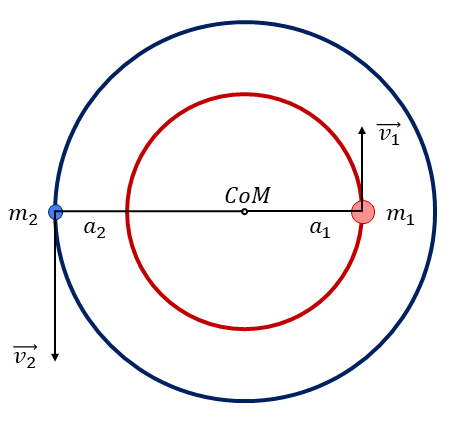

We can calculate the initial positions, $a_1$ and $a_2$ as follows.  The center of mass can be described by:

$$
a_1m_1 = a_2m_2
$$

and by definition,

$$
a = a_1 + a_2
$$

You can then solve this system of equations for $a_1$ and $a_2$.

To calculate the initial velocities, we can equate the graviational force with the centripetal force:

$$
\frac{Gm_1m_2}{a^2} = \frac{m_1v_1^2}{a_1} = \frac{m_2v_2^2}{a_2}
$$

and solve for $v_1$ and $v_2$, respectively.

You may find it convenient to write a function that takes input arguments of the two masses and the semi-major axis and outputs the resulting positions and velocities, so that you can recreate the initial conditions more easily later on.  

In [ ]:
def get_circular_binary_IC(m1 = 1., m2 = 0.5, sma = 1.2):
    # solar masses and AU
    # initial conditions
    # assuming a circular orbit
    
    # a = a1 + a2
    # a1*m1 = a2*m2
    # velocity from balancing gravity force and centripetal force
    a1 = sma*m2/(m1 + m2)
    a2 = sma*m1/(m1 + m2)
    v1_circ = (G*m2*a1/sma**2.)**0.5 
    v2_circ = (G*m1*a2/sma**2.)**0.5 
    
    X0 = np.array([[a1, 0., 0.],[-a2, 0., 0.]])
    V0 = np.array([[0., v1_circ, 0.],[0, -v2_circ, 0.]])
    M = np.array([m1, m2])
    
    return X0, V0, M

In [ ]:
X0, V0, M = get_circular_binary_IC()
print(X0)
print(V0)
print(M)

## 2.1 Integration using the Euler method

Let's use the Euler method first, and later we will explore different integration schemes.  In order to include more than one particle, we will need to change the way we calculate the acceleration.  In the single-planet case where the star doesn't move, we only had one source of acceleration.  Now we will have both the acceleration from the force of star 1 on star 2 and the acceleration from the force of star 2 on star 1.  

As a reminder, the acceleration is defined as:

$$
a = G \sum_{i=0}^{i<n}\sum_{j=0,j \neq i}^{j<n} m_j \frac{X_j - X_i}{|X_j - X_i|^3}
$$

Depending on how you wrote your code above, you may be able to reuse your Euler step function and your function that performs the integration loop, but you will need to rewrite the portion that calculates the acceleration.  I recommend writing a code that is general enough to handle any number of stars so that we can reuse it later for larger systems.

*Hint: Calculating the acceleration will require two for loops to sum over all pairs of different particles.  This will be slow for large numbers of particles, but there is a work-around involving vector notation that you can incorporate later if you finish this workshop early (and/or if this peaks your interest).  I will provide the link with information on the vector format at the end.*

In [ ]:
# This is probably the form that most people will write.  It will work perfectly fine, but it will get slow for large N.
def get_acc(X, M, G):
    # sum up the acceleration from all the particles
    A = np.zeros_like(X)
    for i, m1 in enumerate(M):   
        for j, m2 in enumerate(M):
            if (i != j):
                Xd = X[i] - X[j]
                r = np.linalg.norm(Xd) # get the length of the vector
                A[i] += -(G*m2*Xd)/r**3
    return A


# This is a faster formula, though is probably not the first thing that comes to mind!
def get_acc_vector(X, M, G, **kwargs):
    # vectorized formula for calculating the acceleration for all masses (without a loop)
    # https://medium.com/swlh/create-your-own-n-body-simulation-with-python-f417234885e9
    # with minor modification to avoid inf (and nan) values and return with my vector format
    
    x = X[:,0:1]
    y = X[:,1:2]
    z = X[:,2:3]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # matrix that stores 1/r^3 for all particle pairwise particle separations 
    # softening can be used to avoid very close encounters that would not be resolved and would cause energy errors
    softening = 0
    if ('softening' in kwargs):
        softening = kwargs['softening']
    r2 = dx**2. + dy**2. + dz**2. + softening**2.

    # this r2 will have zeros in the diagonal where i = j
    # to avoid infs when we take the inverse of this, I will set those values to one here and then zero afterwards 
    np.fill_diagonal(r2, 1.)
    inv_r3 = r2**(-1.5)
    np.fill_diagonal(inv_r3, 0.)

    # the @ operator computes the matrix product
    ax = G*(dx*inv_r3) @ M
    ay = G*(dy*inv_r3) @ M
    az = G*(dz*inv_r3) @ M
    
    return np.vstack((ax,ay,az)).T


# this function is nearly identical to above, but I'm including the optional kwargs here 
#  (which could be used to add "softening") and using the vectorized acceleration
def euler(X, V, dt, M, G, **kwargs):
    # implement Euler step (1st order)
    
    # get the acceleration
    
    # non-vectorized method
    # A = get_acc(X, M, G)      
    
    # vectorized method
    A = get_acc_vector(X, M, G, **kwargs)
    
    X_new = X + V*dt
    V_new = V + A*dt 
    
    return (X_new, V_new)


# this function is nearly identical to the above, but I'm allowing for kwargs as well (which I will use later)
def integrate_nbody(X0, V0, t_arr, M, G, integrator = euler, **kwargs):

    X_arr = [X0]
    V_arr = [V0]  
    step = []
    for i,t in enumerate(t_arr[0:-1]):
        dt = t_arr[i + 1] - t
        
        # this acceleration check will be helpful for our leapfrog integrator later on
        # for now A will always be none, and it will be ignored by the integrator
        
        A = None
        if (len(step) > 2):
            A = step[2]
        
        step = integrator(X_arr[i], V_arr[i], dt, M, G, **kwargs)
        X_arr += [step[0]]
        V_arr += [step[1]]

    return (np.array(X_arr), np.array(V_arr))

## 2.2 Functions to calculate the total energy and angular momentum

You will need to rewrite your functions to calculate the energy and angular momentum values to sum over all the stars.  Again, I recommend writing your code in a general form so that you can reuse it for any number of stars.  

The total energy can be written as:

$$
E = \sum_{i=0}^{i<n}\left(KE_i + PE_i\right)
$$

$$
KE_i = \frac{1}{2}m_i\lVert V_i\rVert^2.
$$

$$
PE_i = \sum_{j=0; j\ne i}^{j < n}\frac{-Gm_im_j}{\lVert X_i - X_j\rVert}
$$

and the total angular momentum as:

$$
L = \sum_{i=0}^{i<n} m_iX_i \times V_i
$$

where $n$ is the number of stars.

*Hint, both the energy and angular momentum calculations will require for loops.  The energy equation will require two for loops, since the potential energy is the sum over all pairs of different particles.*

In [ ]:
def get_E_nbody(X, V, M, G):
    # X and V have dimesions of (N_timesteps, N_particles, 3)
    s, n, _ = X.shape
    KE = np.zeros(s)
    PE = np.zeros(s)
    for i in range(n):
        # get the KE
        KE += 0.5*M[i]*np.linalg.norm(V[:,i,:], axis=1)**2.
        
        # get the PE
        for j in range(n):
            if (j > i):
                Xd = X[:,i,:] - X[:,j,:]
                PE += -G*M[i]*M[j]/np.linalg.norm(Xd, axis=1)
    return KE + PE
            
# Not sure if this is correct
def get_L_nbody(X, V, M):
    s, n, k = X.shape
    L = np.zeros((s,k))
    for i in range(n):
        L += M[i]*np.cross(X[:,i,:], V[:,i,:], axis=1)
        
    return L

You may also need to rewrite how you plot the results, so that you can accommodate additional particles.

In [ ]:
# I added a lot of "bells and whistles" to this plotting code which are not strictly necessary!
def create_figure_nbody(X_arr, t_arr, E, L, xlim = None, ylim = None, axes = None, linestyle = 'solid', linealpha = 1, 
                        cmap_name = 'tab10', color_by_variable = None, vmin = None, vmax = None):
    
    _, n, _ = X_arr.shape
        
    # cycle through the default colors (in case I want to overplot different integrators)
    cmap = plt.colormaps[cmap_name]
    n_cmap = n
    # for descrete colormaps
    if (cmap.N < 256):
        n_cmap = np.max([cmap.N,  n])
    colors = cmap(np.linspace(0, 1, n_cmap))
    if (color_by_variable is not None):
        if (vmin is None):
            vmin = np.min(color_by_variable)
        if (vmax is None):
            vmax = np.max(color_by_variable)
        colors = cmap(np.clip((color_by_variable - vmin)/(vmax - vmin), 0, 1))

    # make a grid so that I can have the x,y plot on top and then the energy and angular momentum plots below
    # the bottom plots share an x-axis
    if (axes is None):
        f = plt.figure(figsize = (4,8))
        outer = gridspec.GridSpec(2, 1, height_ratios = [1.5, 1], figure = f) 
        gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])
        ax1 = plt.subplot(gs1[0])
        gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[1], hspace = 0)
        ax2 = plt.subplot(gs2[0])
        ax3 = plt.subplot(gs2[1])
    else:
        ax1, ax2, ax3 = axes
        f = None
        
    
    ax1.plot([0],[0],'x', color = 'black')
    for i in range(n):
        ax1.plot(X_arr[:,i,0],X_arr[:,i,1], linestyle = linestyle, c = colors[i], alpha = linealpha)
        ax1.plot(X_arr[-1,i,0],X_arr[-1,i,1], 'o', c = colors[i])
    ax1.set_xlabel('x [AU]')
    ax1.set_ylabel('y [AU]')
    if (xlim is not None):
        ax1.set_xlim(xlim)
    else:
        ax1.set_xlim(np.min(X_arr[:,:,0]),np.max(X_arr[:,:,0]))
    if (ylim is not None):
        ax1.set_ylim(ylim)
    else:
        ax1.set_ylim(np.min(X_arr[:,:,1]),np.max(X_arr[:,:,1]))
    ax1.set_aspect('equal')

    
    cmap = plt.colormaps['tab10']
    colors = cmap(np.linspace(0, 1, 10))
    ax2.plot(t_arr, abs((E - E[0])/E[0]), linestyle = linestyle, c = colors[0])
    ax2.set_xlabel('time [yr]')
    ax2.set_ylabel('|(E - E0)/E0|')
    ax2.set_yscale('log')

    if (L[0,0] != 0):
        ax3.plot(t_arr, abs((L[:,0] - L[0,0])/L[0,0]), linestyle = linestyle, c = colors[0]) #x
    if (L[0,1] != 0):
        ax3.plot(t_arr, abs((L[:,1] - L[0,1])/L[0,1]), linestyle = linestyle, c = colors[1]) #y
    if (L[0,2] != 0):
        ax3.plot(t_arr, abs((L[:,2] - L[0,2])/L[0,2]), linestyle = linestyle, c = colors[2]) #z
    ax3.set_xlabel('time [yr]')
    ax3.set_ylabel('|(A - A0)/A0|')
    ax3.set_yscale('log')
    
    ax3.sharex(ax2)
    
    
    return (f, ax1, ax2, ax3)

## 2.3 Now let's test our code!

Use your functions from above to integrate your binary systems using the Euler method over the times in your time array.  Then calculate the energy and angular momentum values at each time step and plot the results (using your functions from above).

Similarly to the planet example above, here you should expect closed orbits.  

In [ ]:
# set the initial conditions
X0, V0, M = get_circular_binary_IC()
t_arr = np.arange(0., 4., 1e-3)

# integrate
X_arr, V_arr = integrate_nbody(X0, V0, t_arr, M, G)

# calculate the energy and angular momentum
E = get_E_nbody(X_arr, V_arr, M, G)
L = get_L_nbody(X_arr, V_arr, M)

# plot the result
_ = create_figure_nbody(X_arr, t_arr, E, L)

If you didn't get a closed orbit, try decreasing the time step.  Notice how the energy and angular momentum conservation behave as  you change the time step.

# 3. Try a few other initial conditions

At this point all the "heavy lifting" in coding for the Euler method is finished (phew!).  Now let's have fun testing with different initial conditions.

## 3.1 Eccentric binary

One set of initial condititions that you can try is an eccentric binary.  This setup would be similar to the eccentric planet orbit from above with a slight modification.  You can define the velocity for one of the stars as $v_{1,eccentric} = \beta v_{1,circular}$ where $0 < \beta < 1$. Then the velocity of the other star can be found by conservation of momentum.

In [ ]:
# initial conditions for eccentric binary
def get_eccentric_binary_IC(m1 = 1., m2 = 0.5, sma = 1.2, beta = 0.8):
    X0, V0, M = get_circular_binary_IC(m1, m2, sma)

    beta = 0.8
    V1ecc = V0[0][1]*beta
    V2ecc = m1/m2*V1ecc # from conservation of momentum
    V0 = np.array([[0,V1ecc,0],[0,-V2ecc,0]])

    return X0, V0

In [ ]:
X0, V0 = get_eccentric_binary_IC(1., 0.5, 1.5, 0.8)
t_arr = np.arange(0., 4., 1e-4)

print(X0)
print(V0)

In [ ]:
# integrate
X_arr, V_arr = integrate_nbody(X0, V0, t_arr, M, G)

# calculate the energy and angular momentum
E = get_E_nbody(X_arr, V_arr, M, G)
L = get_L_nbody(X_arr, V_arr, M)

# plot the result
_ = create_figure_nbody(X_arr, t_arr, E, L)

## 3.2 binary + single scattering

In dense stellar environments, like star clusters, binary stars and single stars can come close enough together to interact gravitationally.  We call these binary + single, or 2+1, scattering events, and they play key roles in many areas of stellar astrophysics (e.g., overall star cluster evolution, direct stellar collisions, gravitational wave precursor formation, etc.). 

Let's define some initial conditions for a 2+1 scattering event and then integrate it.

We can define these initial conditions by creating an initial binary and then adding in a third star that approaches the binary at some offset position (often called an "impact parameter") and velocity.  Write a function to produce tjese 2+1 initial conditions, integrate it forward in time using the Euler method, and plot the results.

After you have this working, try different time steps and see how this changes the results.

In [ ]:
def get_scatter_IC(m1 = 1., m2 = 0.5, m3 = 0.9, sma = 0.7, X3 = None, V3 = None, beta = None):
    # initial conditions
    # binary will be m1 + m2
    # if beta is not None then use the eccentric binary initial conditions, otherwise use the circular binary

    if (beta is not None):
        X12, V12, _ = get_eccentric_binary_IC(m1, m2, sma, beta)
    else:
        X12, V12,_ = get_circular_binary_IC(m1, m2, sma)

    # tertiary at some random position coming toward the binary
    if (X3 is None):
        X3 = [np.random.random()*sma, np.random.random()*sma*sma, 0]
    if (V3 is None):
        V3 = [-np.random.random()*V12[0,1], 0, 0]

    X0 = np.append(X12,[X3], axis=0)
    V0 = np.append(V12,[V3], axis=0)
    M = np.array([m1, m2, m3])
    
    return (X0, V0, M)

In [ ]:
# get the initial conditions
X0, V0, M = get_scatter_IC(X3 = [5, 0.6, 0], V3 = [-1, 0, 0])
#t_arr = np.arange(0., 10., 1e-3)
t_arr = np.arange(0., 10., 1e-4)
#t_arr = np.arange(0., 10, 1e-5)

# integrate
X_arr_e, V_arr_e = integrate_nbody(X0, V0, t_arr, M, G)

# calculate the energy and angular momentum
E_e = get_E_nbody(X_arr_e, V_arr_e, M, G)
L_e = get_L_nbody(X_arr_e, V_arr_e, M)

# plot the result
f_e, a1_e, a2_e, a3_e = create_figure_nbody(X_arr_e, t_arr, E_e, L_e, xlim = [-3,3], ylim = [-3,3])

### Questions to consider:

- How does the result change when you change the time step?
- Do you think your result is accurate?  How do you know?
- How would you determine what the "correct" result is?

# 4.  Write a "leapfrog" second-order integrator

The Euler method is simple to code, but in many cases it requires very small time steps in order to achieve a low-enough energy error to trust the results.  Next we will code up a second-order integrator, known as the [leapfrog "kick - drift - kick"](https://en.wikipedia.org/wiki/Leapfrog_integration) or velocity [Verlet](https://en.wikipedia.org/wiki/Verlet_integration).

Write a function below that has input arguments of position, velocity, time step (and probably also mass and your graviational constant) at the current time, $t$, and applies the leapfrog method to advance the particles to the next position and velocity, at $t + dt$.   Specifically, this function should perform the following "kick - drift - kick" calculations:

$
v_{t+\frac{dt}{2}} = v_{t} + a_{t}\frac{dt}{2}
$

$
r_{t+dt} = r_{t} + v_{t+\frac{dt}{2}}dt
$

$
v_{t+dt} = v_{t+\frac{dt}{2}} + a_{t+dt}\frac{dt}{2} 
$

After you write this leapfrog function, use it with your integrator (the same that you used for the Euler method) to integrate the 2+1 scattering event over the same time steps as above.  Plot your results using your plotting code, and compare with the results of the Euler method.  

In [ ]:
def leapfrog(X, V, dt, M, G, **kwargs):
    # if the user suplies the acceleration from the last step, this will avoid having to calculate it again
    A = None
    if ('A' in kwargs):
        A = kwargs['A']
    if (A is None):
        A = get_acc_vector(X, M, G, **kwargs)
    
    # 1/2 kick
    V_half = V + 0.5*A*dt
    
    # drift
    X_new = X + V_half*dt
    
    # get the next acceleration values (using vectorized method)
    A2 = get_acc_vector(X_new, M, G, **kwargs) 
    
    # 1/2 kick
    V_new = V_half + 0.5*A2*dt
    
    return (X_new, V_new, A2)

In [ ]:
# you can use the same initial conditions as for the Euler method (so no need to recalculate them)

# integrate
X_arr_l, V_arr_l = integrate_nbody(X0, V0, t_arr, M, G, integrator = leapfrog)

# calculate the energy and angular momentum
E_l = get_E_nbody(X_arr_l, V_arr_l, M, G)
L_l = get_L_nbody(X_arr_l, V_arr_l, M)

# plot the result
_ = create_figure_nbody(X_arr_l, t_arr, E_l, L_l, xlim = [-3,3], ylim = [-3,3])

### Questions to consider:

- How does the result change when you change the time step?
- How does this result compare with your result using the Euler method?
- Which do you think is the more accurate result (Euler or leapfrog) for a given time step?

# 5. Write a fourth-order Runge-Kutta integrator

Let's go one step further and write a fourth-order integrator using the [Runge-Kutta method](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods), often called "RK4".  This method takes four steps for a given dt to advance the particles in their trajectories. 

Write a function below that has input arguments of position, velocity, time step (and probably also mass and your graviational constant) at the current time, $t$, and applies the RK4 method to advance the particles to the next position and velocity, at $t + dt$.   Specifically, this function should perform the following calculations:

Get the first "coefficients" for the velocity and acceleration, recalling that acceleration, $a$, is a function of position, $X$:

$
X_1 = r_t
$

$
V_1 = v_t
$

$
A_1 = a(X_1) 
$


Get the second coefficients:

$
X_2 = X_1 + V_1\frac{dt}{2}
$

$
V_2 = V_1 + A_1\frac{dt}{2}
$

$
A_2 = a(X_2)
$

Get the third coefficients:

$ 
X_3 = X_1 + V_2\frac{dt}{2}
$

$
V_3 = V_1 + A_2\frac{dt}{2}
$

$
A_3 = a(X_3)
$

Get the fourth coefficients:

$ 
X_4 = X_1 + V_3dt 
$

$
V_4 = V_1 + A_3dt 
$

$
A_4 = a(X_4) 
$

Finally, use these coefficents to advance the particle to the next timestep:

$
r_{t+dt} = r_{t} + \frac{dt}{6}\left(V_1 + 2V_2 + 2V_3 + V_4\right)
$

$
v_{t+dt} = v_{t} + \frac{dt}{6}\left(A_1 + 2A_2 + 2A_3 + A_4\right) 
$

After you write this RK4 function, use it with your integrator (the same that you used for the Euler and leapfrog methods) to integrate the 2+1 scattering event over the same time steps as above.  Plot your results using your plotting code.

Finally, compare the results of the Euler, leapfrog and RK4 methods.  

In [ ]:
def RK4(X, V, dt, M, G, **kwargs):
    # implement RK4 step
    
    # first coefficent
    V1 = V
    A1 = get_acc_vector(X, M, G, **kwargs)
    
    # second coefficient
    V2 = V + 0.5*A1*dt
    A2 = get_acc_vector(X + 0.5*V1*dt, M, G, **kwargs)

    # third coefficient
    V3 = V + 0.5*A2*dt
    A3 = get_acc_vector(X + 0.5*V2*dt, M, G, **kwargs)
      
    # fourth coefficient
    V4 = V + A3*dt
    A4 = get_acc_vector(X + V3*dt, M, G, **kwargs)
        
    X_new = X + dt/6.*(V1 + 2.*V2 + 2.*V3 + V4)
    V_new = V + dt/6.*(A1 + 2.*A2 + 2.*A3 + A4) 
    
    return (X_new, V_new)

In [ ]:
# on my computer, a quick comparison between the two methods above for calculating the acceleration
# using dt = 1e-4
# with the standard acceleration method = 19s
# with vectorized acceleration method = 9s

# you can use the same initial conditions as for the Euler method (so no need to recalculate them)

# integrate
X_arr_r, V_arr_r = integrate_nbody(X0, V0, t_arr, M, G, integrator = RK4)

# calculate the energy and angular momentum
E_r = get_E_nbody(X_arr_r, V_arr_r, M, G)
L_r = get_L_nbody(X_arr_r, V_arr_r, M)

# plot the result
f_r, a1_r, a2_r, a3_r = create_figure_nbody(X_arr_r, t_arr, E_r, L_r, xlim = [-3,3], ylim = [-3,3])

In [ ]:
# one single figure that compares all the different integration schemes
# Euler in solid lines
# leapfrog in dahsed lines
# RK4 in dotted lines
f_e, a1_e, a2_e, a3_e = create_figure_nbody(X_arr_e, t_arr, E_e, L_e, xlim = [-3,3], ylim = [-3,3])
_ = create_figure_nbody(X_arr_l, t_arr, E_l, L_l, xlim = [-3,3], ylim = [-3,3], axes = (a1_e, a2_e, a3_e), linestyle = 'dashed')
_ = create_figure_nbody(X_arr_r, t_arr, E_r, L_r, xlim = [-3,3], ylim = [-3,3], axes = (a1_e, a2_e, a3_e), linestyle = 'dotted')

### Questions to consider:

- How does the result change when you change the time step?
- How does this result compare with your result using the Euler and leapfrog methods?
- Which of these three methods do you think is the most accurate result (for a given time step)?
- Are any of these results "correct"?  How do you know?

# 6. Bonus: integrate a star cluster and animate the results

As a bonus, let's define initial conditions for a star cluster!  I will write this function for you so that you can use it below with your integrator(s).  For the initial conditions, I will draw stars from an initial-mass function (IMF) from Kroupa (see [here](https://ui.adsabs.harvard.edu/abs/1993MNRAS.262..545K/abstract)), distribute the stars in space according to a [Plummer model](https://en.wikipedia.org/wiki/Plummer_model) (and see additional links within the code below), and scale the velocities so that the cluster is in [virial](https://en.wikipedia.org/wiki/Virial_theorem) equilibrium (e.g., it is not collapsing or flying apart), by default.  

In [ ]:
def get_cluster_ICs(N, rpl, G, v_scale = 1):
    # generating a Plummer model:
    # https://en.wikipedia.org/wiki/Plummer_model
    # procedure in appendix from this paper:
    # https://articles.adsabs.harvard.edu/pdf/1974A%26A....37..183A
    # see also the (similar) procedure from Section 2.3 here : 
    # https://ui.adsabs.harvard.edu/abs/2008LNP...760..181K/abstract
    
    # N is the number of stars
    # rpl is the Plummer scale radius
    # v_scale can be used to scale the velocities such that the cluster is born expanding (>1) or contracting (<1)
    

    # masses for an IMF
    # simple (though somewhat outdated) generating function for an IMF
    # https://ui.adsabs.harvard.edu/abs/1993MNRAS.262..545K/abstract 
    # eq 14, table 10 for a1 = 1.3
    def getKTGmasses(Nmass):
        XM = np.random.random(Nmass)
        M = 0.08 + (0.19*XM**1.55 + 0.05*XM**0.6)/(1. - XM)**0.58
        return M
        
    def separate_isotropic_vector(vec):
        N = len(vec)
        X = np.random.random(N)
        theta = 2.*np.pi*np.random.random(N)

        vec_z = (1. - 2.*X)*vec
        vec_x = (vec**2. - vec_z**2.)**0.5*np.cos(theta)
        vec_y = (vec**2. - vec_z**2.)**0.5*np.sin(theta)
        
        return vec_x, vec_y, vec_z
    
    # positions for an Plummer model
    def getPositions(Npos):
        X1 = np.random.random(Npos)
        psi = (X1**(-2./3.) - 1.)**(-0.5)
        r = psi*rpl
        
        return separate_isotropic_vector(r)
    
    
    # velocities for virial equilibrium
    def getVelocities(Nvel, Mcl, r):

        # use von Neumann's rejection technique to sample velocity distribution
        # this is might be slow...
        v = np.zeros_like(r)
        for i in range(len(v)):
            # escape velocity at r 
            vesc = (2.*G*Mcl/rpl*(1 + (r[i]/rpl)**2.)**-0.5)**0.5*v_scale
            
            done = False
            while (not done):
                X4 = np.random.random()
                X5 = np.random.random()
                g = X4**2.*(1. - X4**2.)**(7./2.)
                if (X5 < 10.*g):
                    v[i] = X4*vesc
                    done = True        
        
        return separate_isotropic_vector(v)
    
    # use the functions above the define the cluster initial conditions
    M = getKTGmasses(N)
    x,y,z = getPositions(N)
    r = (x**2. + y**2. + z**2.)**0.5
    vx,vy,vz = getVelocities(N, np.sum(M), r)

    return M, np.vstack((x,y,z)).T, np.vstack((vx,vy,vz)).T

## 5.1 Integrate the cluster

Use one of your integration methods from above to integrate this cluster forward in time and plot the results using your plotting function.

Some questions to consider:
- What time step should you choose?  
  o *Hint: often we define time steps as some fraction of the time it would take for a typical particle (i.e., star) moving at a typical velocity to cross the system.*
- Should you redefine G here?  
  o *Hint: typical units for star clusters are parsecs, solar masses and Myr.*
- Which integrator should you use?
- What is the best way to visualize this?  (Will your current plotting code work?)
- What would happen in your code if 2 stars come very close together?  
  o *Hint: You may want to account for this by applying ["softening"](https://en.wikipedia.org/wiki/N-body_simulation#Softening) when calculating your acceleration.*
  
  
Note, you may want to start with a small number of time steps and a small number of stars to see how long the calculation will take.  Then you can increase your number of time steps and/or your number of stars gradually (so you don't overwork your computer).

In [ ]:
# initial conditions
# use units of solar masses, pc and Myr
G = constants.G.to(units.pc**3./units.solMass/units.Myr**2.).value
N = 100
rpl = 2. # a scale radius

M, X0, V0 = get_cluster_ICs(N, rpl, G)

In [ ]:
# what should we choose for the time step?
# we take some fraction of the crossing time
# I will simply estimate this using the cluster initial conditions
size = np.std(np.linalg.norm(X0, axis=1))
speed = np.mean(np.linalg.norm(V0, axis=1))
tcr = size/speed
print(f'tcr (Myr) = {tcr}')

t_arr = np.arange(0., 2*tcr, tcr*1e-4)

In [ ]:
# integrate and plot with RK4 
X_arr_r, V_arr_r = integrate_nbody(X0, V0, t_arr, M, G, integrator = RK4, softening = (50*units.solRad).to(units.pc).value)

E_r = get_E_nbody(X_arr_r, V_arr_r, M, G)
L_r = get_L_nbody(X_arr_r, V_arr_r, M)

_ = create_figure_nbody(X_arr_r, t_arr, E_r, L_r, xlim = [-4*rpl,4*rpl], ylim = [-4*rpl,4*rpl], linealpha = 0.2, 
                       cmap_name = 'viridis', color_by_variable = M, vmin = 0, vmax = 1)

In [ ]:
# check with the leapfrog integrator
X_arr_l, V_arr_l = integrate_nbody(X0, V0, t_arr, M, G, integrator = leapfrog, softening = (50*units.solRad).to(units.pc).value)

E_l = get_E_nbody(X_arr_l, V_arr_l, M, G)
L_l = get_L_nbody(X_arr_l, V_arr_l, M)

_ = create_figure_nbody(X_arr_l, t_arr, E_l, L_l, xlim = [-4*rpl,4*rpl], ylim = [-4*rpl,4*rpl], linealpha = 0.2, 
                       cmap_name = 'viridis', color_by_variable = M, vmin = 0, vmax = 1)

## 5.2 Create a simple animation using ```Plotly```

[```Plotly```](https://plotly.com/python/), and particularly ```plotly.express```, provides a relatively easy way to create interactive figures, including simple animations, in Python.  Below is an example of how to animate the star cluster model using Plotly.

In [ ]:
# create a simple animation with plotly
# https://plotly.com/python/animations/
import plotly.express as px
import pandas as pd

In [ ]:
# format the data appropriately
df = pd.DataFrame()
M_list = []
t_list = []
x_list = []
y_list = []
t_step = 100 # take every 100 time steps (otherwise it may be too much for plotly)
i = 0
while (i < len(t_arr)):
    M_list += list(M)
    t_list += [t_arr[i]]*len(M)
    x_list += list(X_arr_r[i,:,0])
    y_list += list(X_arr_r[i,:,1])
    i += t_step
df['M'] = M_list
df['t'] = t_list
df['x'] = x_list
df['y'] = y_list

df

In [ ]:
px.scatter(df, x = "x", y = "y", animation_frame = "t", animation_group = "M", color = "M", 
           range_x = [-6,6], range_y = [-6,6], width = 600, height = 600)

# Concluding remarks

Other folks have spent years (and sometimes entire careers) dedicated to building efficient N-body integrators.  This workshop is not meant to replace those well tested tools, but instead to peel back the veil a bit so that you can begin to understand their inner workings.  If your research requires (or could benefit from) direct gravitational integration, I recommend that you look at these tools first. 

- [nbody : the gold standard for star cluster direct N-body](https://people.ast.cam.ac.uk/~sverre/web/pages/nbody.htm) 
- [AMUSE : rich toolkit with many different tools, including N-body integrators](https://www.amusecode.org/)
- [rebound: great new-ish N-body toolkit](https://rebound.readthedocs.io/en/latest/)
- [Mercury : classic planetary-system N-body integrator](https://github.com/smirik/mercury)
- [galpy : toolkit for galactic dynamics](https://docs.galpy.org/en/v1.8.1/)



Also, here are some additional links that I found useful when constructing this notebook:
- https://faculty1.coloradocollege.edu/~sburns/toolbox/ODE_II.html
- https://www.tat.physik.uni-tuebingen.de/~schaefer/teach/fum2020/f/nbody_slides.pdf
- https://radio.astro.gla.ac.uk/a1dynamics/twobody.pdf
- https://medium.com/swlh/create-your-own-n-body-simulation-with-python-f417234885e9 (with acceleration vector notation), and accompanying code on GitHub : https://github.com/pmocz/nbody-python
- http://spiff.rit.edu/richmond/nbody/OrbitRungeKutta4.pdf
- https://electroweak.blog/en/solving-the-n-body-problem-interacting-gravitationally-using-python/